{'airplane': 0,
 'automobile': 1,
 'bird': 2,
 'cat': 3,
 'deer': 4,
 'dog': 5,
 'frog': 6,
 'horse': 7,
 'ship': 8,
 'truck': 9}

In [27]:
import torchvision

# 图像增广
IMAGE_SIZE = 32

mean, std = [0.4914, 0.4822, 0.4465], [0.247, 0.243, 0.261]

transform_train = torchvision.transforms.Compose([
    # 在高度和宽度上将图像RESIZE
    torchvision.transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),  # Resize
    torchvision.transforms.RandomHorizontalFlip(0.1),
    torchvision.transforms.RandomRotation(20),
    # torchvision.transforms.ColorJitter(brightness=0.1,  #随机颜色抖动
    #                                    contrast=0.1,
    #                                    saturation=0.1),
    torchvision.transforms.ToTensor(),
    # 标准化图像的每个通道
    torchvision.transforms.Normalize(mean, std)])

# 在测试期间，只对图像执行标准化，以消除评估结果中的随机性。
transform_test = torchvision.transforms.Compose([
    torchvision.transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean, std)])

transform_train

Compose(
    Resize(size=(32, 32), interpolation=bilinear, max_size=None, antialias=warn)
    RandomHorizontalFlip(p=0.1)
    RandomRotation(degrees=[-20.0, 20.0], interpolation=nearest, expand=False, fill=0)
    ToTensor()
    Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.247, 0.243, 0.261])
)

In [28]:
from torchvision import datasets
import torch
from torch.utils.data import DataLoader

torch.manual_seed(1)

# load and transform
train_dataset = datasets.CIFAR10(root='../data', train=True, download=False, transform=transform_train)
validation_dataset = datasets.CIFAR10(root='../data', train=False, download=False, transform=transform_test)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=100)
validation_loader = torch.utils.data.DataLoader(dataset=validation_dataset, batch_size=100)

In [29]:
# 训练数据集信息
print("训练数据集:")
print("批次数量:", len(train_loader))
print("总样本数量:", len(train_loader.dataset))
print("一个批次的数据形状:", next(iter(train_loader))[0].shape)
print("一个批次的标签形状:", next(iter(train_loader))[1].shape)

# 验证数据集信息
print("\n验证数据集:")
print("批次数量:", len(validation_loader))
print("总样本数量:", len(validation_loader.dataset))
print("一个批次的数据形状:", next(iter(validation_loader))[0].shape)
print("一个批次的标签形状:", next(iter(validation_loader))[1].shape)

训练数据集:
批次数量: 500
总样本数量: 50000
一个批次的数据形状: torch.Size([100, 3, 32, 32])
一个批次的标签形状: torch.Size([100])

验证数据集:
批次数量: 100
总样本数量: 10000
一个批次的数据形状: torch.Size([100, 3, 32, 32])
一个批次的标签形状: torch.Size([100])


In [30]:
import numpy as np
from matplotlib import pyplot as plt

plt.rcParams['font.family'] = 'Microsoft YaHei'


def show_data(img):
    try:
        plt.imshow(img[0])
    except Exception as e:
        print(e)
    print(img[0].shape, img[0].permute(1, 2, 0).shape)
    plt.imshow(img[0].permute(1, 2, 0))
    plt.title('实际标签: ' + str(img[1]))
    plt.show()


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Invalid shape (3, 32, 32) for image data
torch.Size([3, 32, 32]) torch.Size([32, 32, 3])


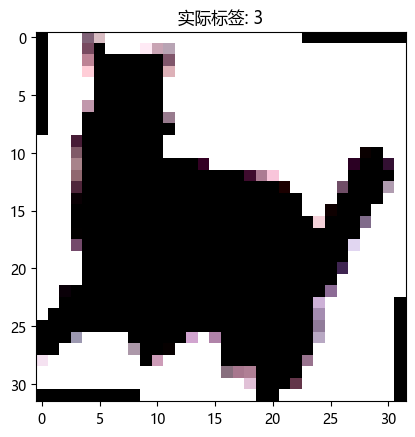

In [31]:
show_data(train_dataset[4564])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Invalid shape (3, 32, 32) for image data
torch.Size([3, 32, 32]) torch.Size([32, 32, 3])


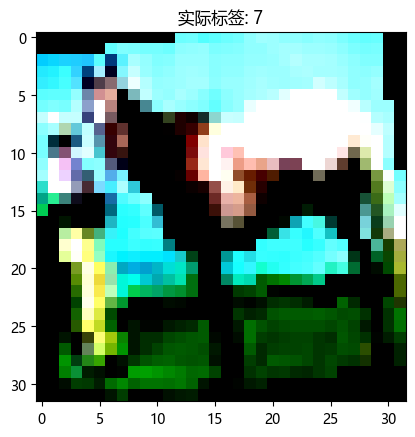

In [32]:
show_data(train_dataset[8976])

In [33]:
train_dataset.classes

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

In [34]:
train_dataset.class_to_idx

{'airplane': 0,
 'automobile': 1,
 'bird': 2,
 'cat': 3,
 'deer': 4,
 'dog': 5,
 'frog': 6,
 'horse': 7,
 'ship': 8,
 'truck': 9}

In [35]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [36]:
def get_net():
    resnet = torchvision.models.resnet34(pretrained=True)

    # Substitute the FC output layer
    resnet.fc = torch.nn.Linear(resnet.fc.in_features, 10)
    torch.nn.init.xavier_uniform_(resnet.fc.weight)
    return resnet

In [37]:
import time


def train(net, train_dataloader, valid_dataloader, criterion, optimizer, scheduler=None, epochs=10, device='cpu',
          checkpoint_epochs=10):
    valid_loss = None
    valid_accuracy = None
    start = time.time()
    print(f'Training for {epochs} epochs on {device}')

    for epoch in range(1, epochs + 1):
        print(f"--> Epoch {epoch}/{epochs} |", end=' ')

        net.train()  # put network in train mode for Dropout and Batch Normalization
        train_loss = torch.tensor(0., device=device)  # loss and accuracy tensors are on the GPU to avoid data transfers
        train_accuracy = torch.tensor(0., device=device)
        for X, y in train_dataloader:
            X = X.to(device)
            y = y.to(device)
            preds = net(X)
            loss = criterion(preds, y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            with torch.no_grad():
                train_loss += loss * train_dataloader.batch_size
                train_accuracy += (torch.argmax(preds, dim=1) == y).sum()

        if valid_dataloader is not None:
            net.eval()  # put network in train mode for Dropout and Batch Normalization
            valid_loss = torch.tensor(0., device=device)
            valid_accuracy = torch.tensor(0., device=device)
            with torch.no_grad():
                for X, y in valid_dataloader:
                    X = X.to(device)
                    y = y.to(device)
                    preds = net(X)
                    loss = criterion(preds, y)

                    valid_loss += loss * valid_dataloader.batch_size
                    valid_accuracy += (torch.argmax(preds, dim=1) == y).sum()

        if scheduler is not None:
            scheduler.step()

        print("Training Loss: {:.2f}".format(train_loss / len(train_dataloader.dataset)), end='')

        if valid_dataloader is not None:
            print(" | Validation Loss: {:.2f}".format(valid_loss / len(valid_dataloader.dataset)),
                  "| Validation Accuracy: {:.2f}%".format(100 * valid_accuracy / len(valid_dataloader.dataset)), end='')

        if epoch % checkpoint_epochs == 0:
            torch.save({
                'epoch': epoch,
                'state_dict': net.state_dict(),
                'optimizer': optimizer.state_dict(),
            }, './checkpoint.pth.tar')

        print()

    end = time.time()
    print(f'Total training time: {end - start:.1f} seconds')
    return net


In [38]:
lr, weight_decay, epochs = 1e-5, 5e-4, 20

net = get_net().to(device)
net

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [39]:
# Standard CrossEntropy Loss for multi-class classification problems
criterion = torch.nn.CrossEntropyLoss()

# params_1x are the parameters of the network body, i.e., of all layers except the FC layers
params_1x = [param for name, param in net.named_parameters() if 'fc' not in str(name)]
optimizer = torch.optim.Adam([{'params': params_1x}, {'params': net.fc.parameters(), 'lr': lr * 10}], lr=lr,
                             weight_decay=weight_decay)

net = train(net, train_loader, validation_loader, criterion, optimizer, None, epochs, device)

Training for 20 epochs on cuda
--> Epoch 1/20 | Training Loss: 2.01 | Validation Loss: 1.66 | Validation Accuracy: 44.50%
--> Epoch 2/20 | Training Loss: 1.36 | Validation Loss: 1.44 | Validation Accuracy: 54.76%
--> Epoch 3/20 | 

KeyboardInterrupt: 